## Importing Libraries

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random

## Data Prepration 

In [37]:
Dataset_path=Path("./Dataset/")
Folders=Dataset_path.glob('*')
label_map={"Cat":0,"Dog":1,"Horse":2,"Human":3}
image_data=[]
labels=[]

for folder in Folders:
    label=str(folder).split("\\")[-1]
    for img in folder.glob('*.jpg'):
        Image=image.load_img(img,target_size=(35,35))
        Image=image.img_to_array(Image)
        image_data.append(Image)
        labels.append(label_map[label])


### Shuffling Data

In [18]:
Combined_data=list(zip(image_data,labels))
random.shuffle(Combined_data)
image_data,labels=list(zip(*Combined_data))

image_data=np.array(image_data,dtype="int32")
labels=np.array(labels,dtype="int32")
print(image_data.shape,labels.shape)

(808, 35, 35, 3) (808,)


### Visualizing Shuffled data

2 ->


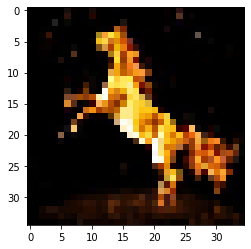

3 ->


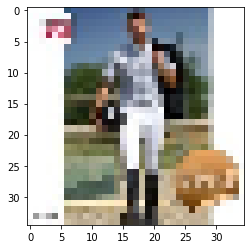

2 ->


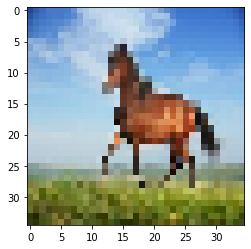

3 ->


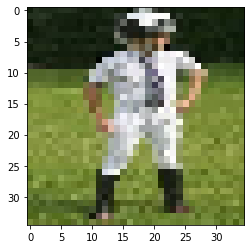

1 ->


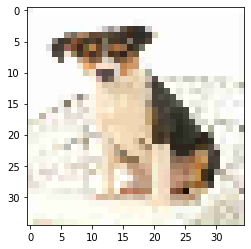

0 ->


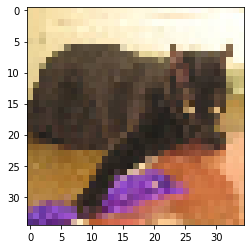

3 ->


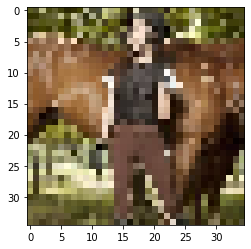

1 ->


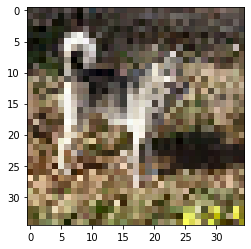

2 ->


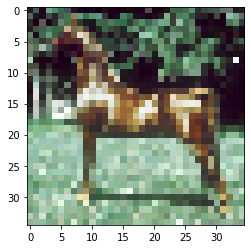

1 ->


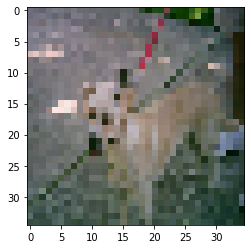

In [19]:
for i in range(10):
    print(labels[i],"->")
    plt.imshow(image_data[i])
    plt.show()

### Class Wise Data

In [20]:
#reshaping data like 2d matrix
image_data=image_data.reshape((image_data.shape[0],-1))
print(image_data.shape,labels.shape)

(808, 3675) (808,)


In [21]:
ClassWiseData={}
num_class=len(np.unique(labels))

for classes in range(num_class):
    ClassWiseData[classes]=[]

for data_idx in range(image_data.shape[0]):
    ClassWiseData[labels[data_idx]].append(image_data[data_idx])

for data_idx in range(num_class):
    ClassWiseData[data_idx]=np.array(ClassWiseData[data_idx])

## One vs One Classification Using SVM

In [22]:
def PairData(Data1,Data2):
    """Combines data of two class and returns with label for SVM"""
    
    size1=Data1.shape[0]
    size2=Data2.shape[0]
    total_data=size1+size2
    num_features=Data1.shape[1]

    Processed_data=np.zeros((total_data,num_features))
    Processed_label=np.zeros((total_data,))

    Processed_data[:size1,:]=Data1
    Processed_data[size1:,:]=Data2

    Processed_label[:size1]=1
    Processed_label[size1:]=-1

    return Processed_data,Processed_label

### Implimenting SVM Class

In [23]:
class SVM:
    def __init__(self,C=1.0):
        self.C=C
        self.W=0
        self.bias=0
    
    def hingeloss(self,X,Y):
        loss=0.0
        loss+=0.5*np.dot(self.W,self.W.T)
        for idx in range(X.shape[0]):
            var=Y[idx]*(np.dot(self.W,X[idx].T)+self.bias)
            loss+=max(0,1-var)
        return loss
    
    def fit(self,X,Y,learning_rate=0.001,n_epochs=500,batch_size=100):
        """Implementing batch gradient descent"""
        losses=[]
        self.W=np.zeros(X.shape[1])
        self.bias=0;
        for epoch in range(n_epochs):
            curr_loss=self.hingeloss(X,Y)
            losses.append(curr_loss)
            samples=np.arange(X.shape[0])
            np.random.shuffle(samples)
            for batch_start in range(0,X.shape[0],batch_size):
                grad_w=0.0
                grad_bias=0.0
                for data_point in range(batch_start,batch_size):
                    if data_point < X.shape[0]:
                        sample=samples[data_point]
                        var=Y[sample]*(np.dot(self.W,X[sample].T)+self.bias)
                        if var <= 1:
                            grad_bias+=self.C*Y[sample]
                            grad_w+=self.C*Y[sample]*X[sample]
                self.W=self.W-learning_rate*self.W+learning_rate*grad_w
                self.bias=self.bias+learning_rate*grad_bias
        return self.W,self.bias

### Training The model

In [24]:
def train(X,Y):
    classifier=SVM()
    parameters={}
    for firstClass in range(num_class):
        parameters[firstClass]={}
        for secondClass in range(firstClass+1,num_class):
            Xpair,Ypair=PairData(ClassWiseData[firstClass],ClassWiseData[secondClass])
            wts,b=classifier.fit(Xpair,Ypair)
            parameters[firstClass][secondClass]=(wts,b)
    
    return parameters

allParameters=train(image_data,labels)


### Predict Method

In [25]:
def predictY(X,w,b):
    val=np.dot(X,w.T)+b
    if val>=0:
        return 1
    else:
        return -1

In [26]:
def predict(X):
    count=np.zeros((num_class,))
    for firstClass in range(num_class):
        for secondClass in range(firstClass+1,num_class):
            w,b=allParameters[firstClass][secondClass]
            ypred=predictY(X,w,b)
            if ypred==1:
                count[firstClass]+=1
            else:
                count[secondClass]+=1
    return np.argmax(count) 

### making Prediction

[1. 1. 1. 3.]
Predicted Class->  3
True Class->  3


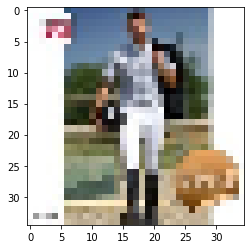

In [35]:
ypred=predict(image_data[1])
print("Predicted Class-> ",ypred)
print("True Class-> ",labels[1])
plt.imshow(image_data[1].reshape(35,35,-1))
plt.show()